## **Research Question**: Can we predict how many fantasy points a NFL player will score?

In the world of fantasy sports and sports betting, gaining an edge is everything. Whether you're competing in a fantasy league with friends for bragging rights (and maybe a bit of cash) or analyzing odds at a professional sportsbook, knowing how players will perform is crucial.

Sportsbooks rely on highly accurate models and projections to turn a profit, while bettors and fantasy players use data-driven insights to make informed decisions. My analysis aims to help fantasy football players and sports bettors navigate the unpredictable and chaotic football season with more confidence.

**Data Problem:** The task is to train and tune multiple regression models including Linear Regression, Support Vector Regression (SVR), an Ensemble model, and a Neural Network just to name a few.

**Expected Results:** The expected result of this project is a well-tuned model that can predict PPR fantasy points with low error.

**Data:**

The data I will be using in this project is from Kaggle and can be found [here](https://www.kaggle.com/datasets/philiphyde1/nfl-stats-1999-2022).

Included in this data is various stats for players and teams on a weekly or yearly basis from the 2012-2023 seasons. This includes stats like receptions, targets, receiving yards, rushing yards, yards after catch, etc. I will only be using the 'yearly_player_data' dataset.

#### Import and Setup

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import time
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
yearly_player_data = pd.read_csv("data/yearly_player_data.csv")

In [3]:
yearly_player_data.head()

,team,player_id,player_name,position,season,depth,pass_attempts,complete_pass,incomplete_pass,passing_yards,...,vacated_receptions,vacated_receiving_yards,vacated_receiving_air_yards,vacated_yards_after_catch,vacated_reception_td,vacated_rush_attempts,vacated_rushing_yards,vacated_run_td,vacated_touches,vacated_total_yards
0,TEN,00-0035676,A.J. Brown,WR,2019,2.0,0.0,0.0,0.0,0.0,...,147.0,1632.0,1886.0,646.0,6.0,185.0,656.0,6.0,383.0,2420.0
1,TEN,00-0035676,A.J. Brown,WR,2020,1.0,0.0,0.0,0.0,0.0,...,62.0,730.0,1015.0,284.0,4.0,8.0,19.0,0.0,176.0,1338.0
2,TEN,00-0035676,A.J. Brown,WR,2021,1.0,2.0,0.0,2.0,0.0,...,74.0,741.0,804.0,331.0,7.0,88.0,365.0,0.0,345.0,2147.0
3,PHI,00-0035676,A.J. Brown,WR,2022,1.0,0.0,0.0,0.0,0.0,...,135.0,1769.0,2911.0,463.0,10.0,83.0,397.0,6.0,724.0,4486.0
4,PHI,00-0035676,A.J. Brown,WR,2023,1.0,0.0,0.0,0.0,0.0,...,47.0,471.0,753.0,217.0,6.0,96.0,438.0,3.0,145.0,911.0


### Understanding The Data

Here we will dive into the data to see what it consists of.

In [4]:
yearly_player_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Columns: 195 entries, team to vacated_total_yards
dtypes: float64(167), int64(22), object(6)
memory usage: 8.4+ MB


In [5]:
yearly_player_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,5663.0,2017.969981,3.347339,2012.0,2015.0,2018.0,2021.0,2023.0
depth,5663.0,1.823415,0.715353,1.0,1.0,2.0,2.0,3.0
pass_attempts,5663.0,38.852552,130.311182,0.0,0.0,0.0,0.0,758.0
complete_pass,5663.0,23.031256,78.500965,0.0,0.0,0.0,0.0,490.0
incomplete_pass,5663.0,12.307081,41.075541,0.0,0.0,0.0,0.0,271.0
...,...,...,...,...,...,...,...,...
vacated_rush_attempts,5304.0,117.018854,108.094482,0.0,22.0,87.0,204.0,411.0
vacated_rushing_yards,5304.0,479.463801,442.960916,0.0,94.0,352.0,781.0,1979.0
vacated_run_td,5304.0,3.359540,3.555581,0.0,0.0,2.0,5.0,19.0
vacated_touches,5304.0,355.601433,293.167502,0.0,123.0,283.0,504.5,1215.0


In [7]:
# List object columns and their value counts
object_columns = yearly_player_data.select_dtypes(include='object').columns

for col in object_columns:
    print("---- %s ----" % col)
    print(yearly_player_data[col].value_counts().sort_index())

---- team ----
team
ARI    199
ATL    169
BAL    188
BUF    182
CAR    165
CHI    190
CIN    184
CLE    182
DAL    174
DEN    194
DET    180
GB     180
HOU    193
IND    189
JAX    193
KC     174
LA     123
LAC    116
LV      63
MIA    189
MIN    172
NE     185
NO     189
NYG    198
NYJ    197
PHI    180
PIT    176
SEA    176
SF     193
TB     184
TEN    182
WAS    204
Name: count, dtype: int64
---- player_id ----
player_id
00-0000865    1
00-0004541    1
00-0006101    2
00-0007091    4
00-0010346    4
             ..
00-0039150    1
00-0039152    1
00-0039163    1
00-0039164    1
00-0039165    1
Name: count, Length: 1579, dtype: int64
---- player_name ----
player_name
A.J. Brown         5
A.J. Derby         3
A.J. Dillon        4
A.J. Green        10
A.J. Jenkins       3
                  ..
Zamir White        2
Zander Horvath     1
Zay Flowers        1
Zay Jones          6
Zonovan Knight     2
Name: count, Length: 1572, dtype: int64
---- position ----
position
QB     819
RB    1492
T

In [8]:
# Removing this column as there is only one value in it
yearly_player_data.drop(columns=['game_type'], inplace=True)

In [9]:
yearly_player_data['fantasy_points_ppr'].head() # This will serve as our target variable

,fantasy_points_ppr
0,217.1
1,246.5
2,180.9
3,303.6
4,293.6


In [10]:
# List seasons and counts
yearly_player_data['season'].value_counts().sort_index()

,count
season,
2012,359
2013,362
2014,387
2015,414
2016,467
2017,486
2018,517
2019,516
2020,549


### Data Preparation

Here we will perform data cleaning to ensure our data is ready for modeling.

**Missing Values**

In [11]:
# Check for missing data and the percentage of the total
missing_data = yearly_player_data.isnull().sum()
missing_percentage = (missing_data / len(yearly_player_data)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
missing_df

,Missing Values,Percentage
team,0,0.000000
player_id,0,0.000000
player_name,0,0.000000
position,0,0.000000
season,0,0.000000
...,...,...
vacated_rush_attempts,359,6.339396
vacated_rushing_yards,359,6.339396
vacated_run_td,359,6.339396
vacated_touches,359,6.339396


In [12]:
# Filter out data that is not missing
missing_df = missing_df.loc[missing_df['Missing Values'] > 0]
missing_df = missing_df.sort_values(by='Percentage', ascending=False)
missing_df

,Missing Values,Percentage
vacated_pass_attempts,359,6.339396
vacated_complete_pass,359,6.339396
vacated_incomplete_pass,359,6.339396
vacated_receiving_air_yards,359,6.339396
vacated_passing_yards,359,6.339396
vacated_passing_air_yards,359,6.339396
vacated_pass_td,359,6.339396
vacated_interception,359,6.339396
vacated_targets,359,6.339396
vacated_receptions,359,6.339396


In [13]:
# Check missing 'college' value
yearly_player_data.loc[yearly_player_data['college'].isnull()]

,team,player_id,player_name,position,season,depth,pass_attempts,complete_pass,incomplete_pass,passing_yards,...,vacated_receptions,vacated_receiving_yards,vacated_receiving_air_yards,vacated_yards_after_catch,vacated_reception_td,vacated_rush_attempts,vacated_rushing_yards,vacated_run_td,vacated_touches,vacated_total_yards
2632,SF,00-0031493,Jarryd Hayne,RB,2015,2.0,0.0,0.0,0.0,0.0,...,19.0,172.0,335.0,81.0,0.0,118.0,473.0,5.0,138.0,658.0


In [14]:
yearly_player_data.loc[yearly_player_data['player_name'] == 'Jarryd Hayne']

,team,player_id,player_name,position,season,depth,pass_attempts,complete_pass,incomplete_pass,passing_yards,...,vacated_receptions,vacated_receiving_yards,vacated_receiving_air_yards,vacated_yards_after_catch,vacated_reception_td,vacated_rush_attempts,vacated_rushing_yards,vacated_run_td,vacated_touches,vacated_total_yards
2632,SF,00-0031493,Jarryd Hayne,RB,2015,2.0,0.0,0.0,0.0,0.0,...,19.0,172.0,335.0,81.0,0.0,118.0,473.0,5.0,138.0,658.0


In [15]:
# Drop row with missing college data
yearly_player_data = yearly_player_data[yearly_player_data['college'].notna()]

In [16]:
# Check correlation between 'vacated' columns and target
vacated_cols = [col for col in yearly_player_data.columns if 'vacated' in col]
vacated_corr = yearly_player_data[vacated_cols + ['fantasy_points_ppr']].corr()
vacated_corr_ppr_points = vacated_corr['fantasy_points_ppr'].drop('fantasy_points_ppr').sort_values(ascending=False)
vacated_corr_ppr_points

,fantasy_points_ppr
vacated_reception_td,-0.009950
vacated_run_td,-0.019996
vacated_receiving_air_yards,-0.025381
vacated_receiving_yards,-0.031731
vacated_yards_after_catch,-0.034927
vacated_pass_td,-0.037739
vacated_interception,-0.039560
vacated_targets,-0.039963
vacated_receptions,-0.040038
vacated_passing_yards,-0.041087


In [17]:
# Drop 'vacated' columns
yearly_player_data.drop(columns=vacated_cols, inplace=True)
yearly_player_data.shape

(5662, 176)

The columns that consisted of missing values were the 'vacated' columns and one missing value from the 'college' column. I removed this one row from the 'college' column as it was a player that only played one season and didn't score many points.

There were 359 missing values from the 'vacated' columns which is around 6.34 of the data. These features also have very low correlation with our target variable, fantasy_points_ppr, so I removed them.

In [18]:
yearly_player_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,5662.0,2017.970505,3.347402,2012.0,2015.0000,2018.000,2021.000,2023.00
depth,5662.0,1.823384,0.715412,1.0,1.0000,2.000,2.000,3.00
pass_attempts,5662.0,38.859414,130.321668,0.0,0.0000,0.000,0.000,758.00
complete_pass,5662.0,23.035323,78.507301,0.0,0.0000,0.000,0.000,490.00
incomplete_pass,5662.0,12.309255,41.078843,0.0,0.0000,0.000,0.000,271.00
...,...,...,...,...,...,...,...,...
average_rush_ypg,5662.0,11.378410,19.303075,-6.0,0.0000,1.130,15.200,131.19
average_ypg,5662.0,NaN,NaN,-inf,19.8425,36.525,65.075,inf
average_ppg,5662.0,NaN,NaN,-inf,4.0300,6.985,11.610,inf
injuries,5662.0,3.138644,2.604406,0.0,1.0000,2.000,4.000,18.00


**'inf' Values**

I noticed there are some columns with weird values like 'inf' and '-inf' as well as some columns with very large numbers in the negatives.

In [20]:
# Get sum of 'inf', '-inf', and extreme negative values
yearly_player_data = yearly_player_data.apply(pd.to_numeric, errors='ignore')

inf_counts = (yearly_player_data == np.inf).sum().sum()
neg_inf_counts = (yearly_player_data == -np.inf).sum().sum()
extreme_neg_counts = (yearly_player_data.select_dtypes(include=[np.number]) < -100).sum().sum()

print("Infinite values: {}".format(inf_counts))
print("Negative infinite values: {}".format(neg_inf_counts))
print("Extreme negative values: {}".format(extreme_neg_counts))

Infinite values: 9
Negative infinite values: 3
Extreme negative values: 89


In [21]:
yearly_player_data.replace([np.inf, -np.inf], np.nan, inplace=True)
print(yearly_player_data.isin([np.inf, -np.inf]).sum().sum())

0


In [22]:
print(yearly_player_data.isnull().sum().sum())

12


In [23]:
# Remove 'inf' and '-inf' samples
yearly_player_data.dropna(inplace=True)

In [24]:
# Get columns with negative values under -100 and count
neg_cols = (yearly_player_data.select_dtypes(include=[np.number]) < -100).sum()
neg_cols = neg_cols[neg_cols > 0]
print("Columns with large negative values and their count:")
print(neg_cols)

Columns with large negative values and their count:
receiving_air_yards             7
passer_rating                  17
delta_pass_ypg                  1
delta_rec_ypg                   1
delta_rush_ypg                  5
delta_ypg                       1
delta_ppg                       2
delta_passer_rating             1
career_receiving_air_yards     44
average_receiving_air_yards     7
dtype: int64


**Passer Rating**

Passer ratings in the NFL are on a scale from 0 to 158.3. For this reason, I will replace any negative values with 0.

In [25]:
# Restrict min passer rating to 0
yearly_player_data['passer_rating'] = yearly_player_data['passer_rating'].apply(lambda x: max(x, 0))
yearly_player_data['delta_passer_rating'] = yearly_player_data['delta_passer_rating'].apply(lambda x: max(x, 0))

**Large Negatives**

In [26]:
neg_cols = (yearly_player_data.select_dtypes(include=[np.number]) < -100).sum()
neg_cols = neg_cols[neg_cols > 0]
print("Columns with large negative values and their count:")
print(neg_cols)

Columns with large negative values and their count:
receiving_air_yards             7
delta_pass_ypg                  1
delta_rec_ypg                   1
delta_rush_ypg                  5
delta_ypg                       1
delta_ppg                       2
career_receiving_air_yards     44
average_receiving_air_yards     7
dtype: int64


In [27]:
# Changing very negative values to values in the 5th percentile
for col in ['receiving_air_yards', 'career_receiving_air_yards', 'average_receiving_air_yards',
            'delta_pass_ypg', 'delta_rec_ypg', 'delta_rush_ypg', 'delta_ypg', 'delta_ppg']:
    min_valid_value = yearly_player_data[col][yearly_player_data[col] > -100].quantile(0.05) #5th percentile
    yearly_player_data[col] = yearly_player_data[col].apply(lambda x: min_valid_value if x < -100 else x)

In [28]:
extreme_neg_counts_after = (yearly_player_data.select_dtypes(include=[np.number]) < -100).sum().sum()
print(f"Extreme negative values after cleanup: {extreme_neg_counts_after}")

Extreme negative values after cleanup: 0


### Visualizing the Data

Here we will visualize some of the data to get a better sense of understanding.

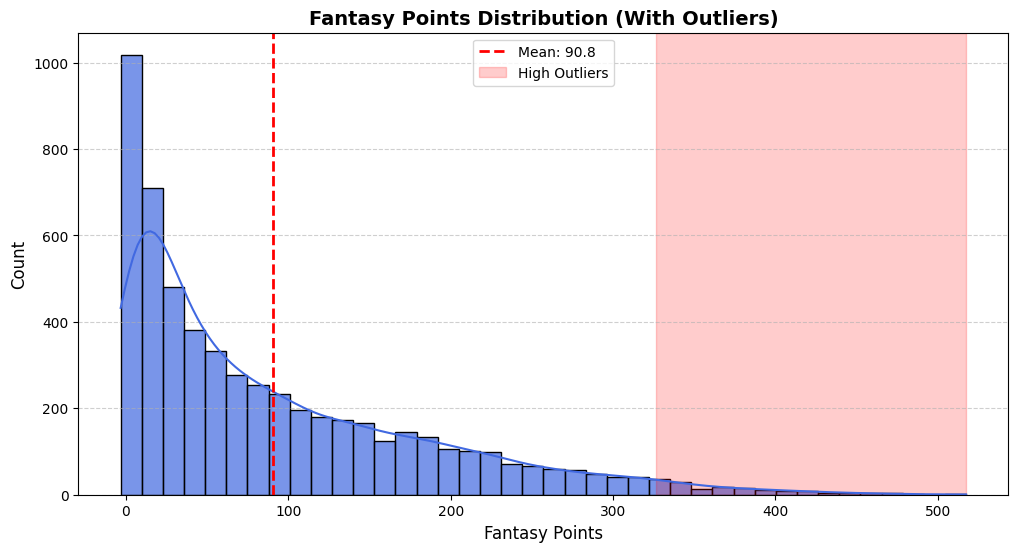

In [29]:
# Create histogram with KDE of Fantasy Points
plt.figure(figsize=(12, 6))
sns.histplot(yearly_player_data, x='fantasy_points_ppr', bins=40, kde=True, color="royalblue", edgecolor="black", alpha=0.7)

mean_val = yearly_player_data['fantasy_points_ppr'].mean()
median_val = yearly_player_data['fantasy_points_ppr'].median()
q1 = yearly_player_data['fantasy_points_ppr'].quantile(0.25)
q3 = yearly_player_data['fantasy_points_ppr'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.1f}")

plt.axvspan(yearly_player_data['fantasy_points_ppr'].max(), upper_bound, color='red', alpha=0.2, label="High Outliers")

plt.legend()
plt.title("Fantasy Points Distribution (With Outliers)", fontsize=14, fontweight='bold')
plt.xlabel("Fantasy Points", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

In [30]:
# Create custom NFL team color palette
nfl_team_colors = {
    'DAL': '#003594',  # Dallas Cowboys
    'ATL': '#A71930',  # Atlanta Falcons
    'NO': '#D3BC8D',   # New Orleans Saints
    'GB': '#203731',   # Green Bay Packers
    'KC': '#E31837',   # Kansas City Chiefs
    'MIN': '#4F2683',  # Minnesota Vikings
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'NE': '#002244',   # New England Patriots
    'SEA': '#002244',  # Seattle Seahawks
    'DET': '#0076B6',  # Detroit Lions
    'LA': '#FF8200',   # Los Angeles Rams
    'PHI': '#004C54',  # Philadelphia Eagles
    'TB': '#D50A0A',   # Tampa Bay Buccaneers
    'LAC': '#0080C6',  # Los Angeles Chargers
    'LV': '#A5ACAF',   # Las Vegas Raiders
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'IND': '#002C5F',  # Indianapolis Colts
    'BUF': '#00338D',  # Buffalo Bills
    'DEN': '#FB4F14',  # Denver Broncos
    'CAR': '#0085CA',  # Carolina Panthers
    'BAL': '#241773',  # Baltimore Ravens
    'MIA': '#008E97',  # Miami Dolphins
    'TEN': '#0C2340',  # Tennessee Titans
    'SF': '#AA0000',   # San Francisco 49ers
    'HOU': '#03202F',  # Houston Texans
    'CHI': '#C83803',  # Chicago Bears
    'ARI': '#97233F',  # Arizona Cardinals
    'CLE': '#311D00',  # Cleveland Browns
    'WAS': '#5A1414',  # Washington Commanders
    'JAX': '#006778',  # Jacksonville Jaguars
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
}

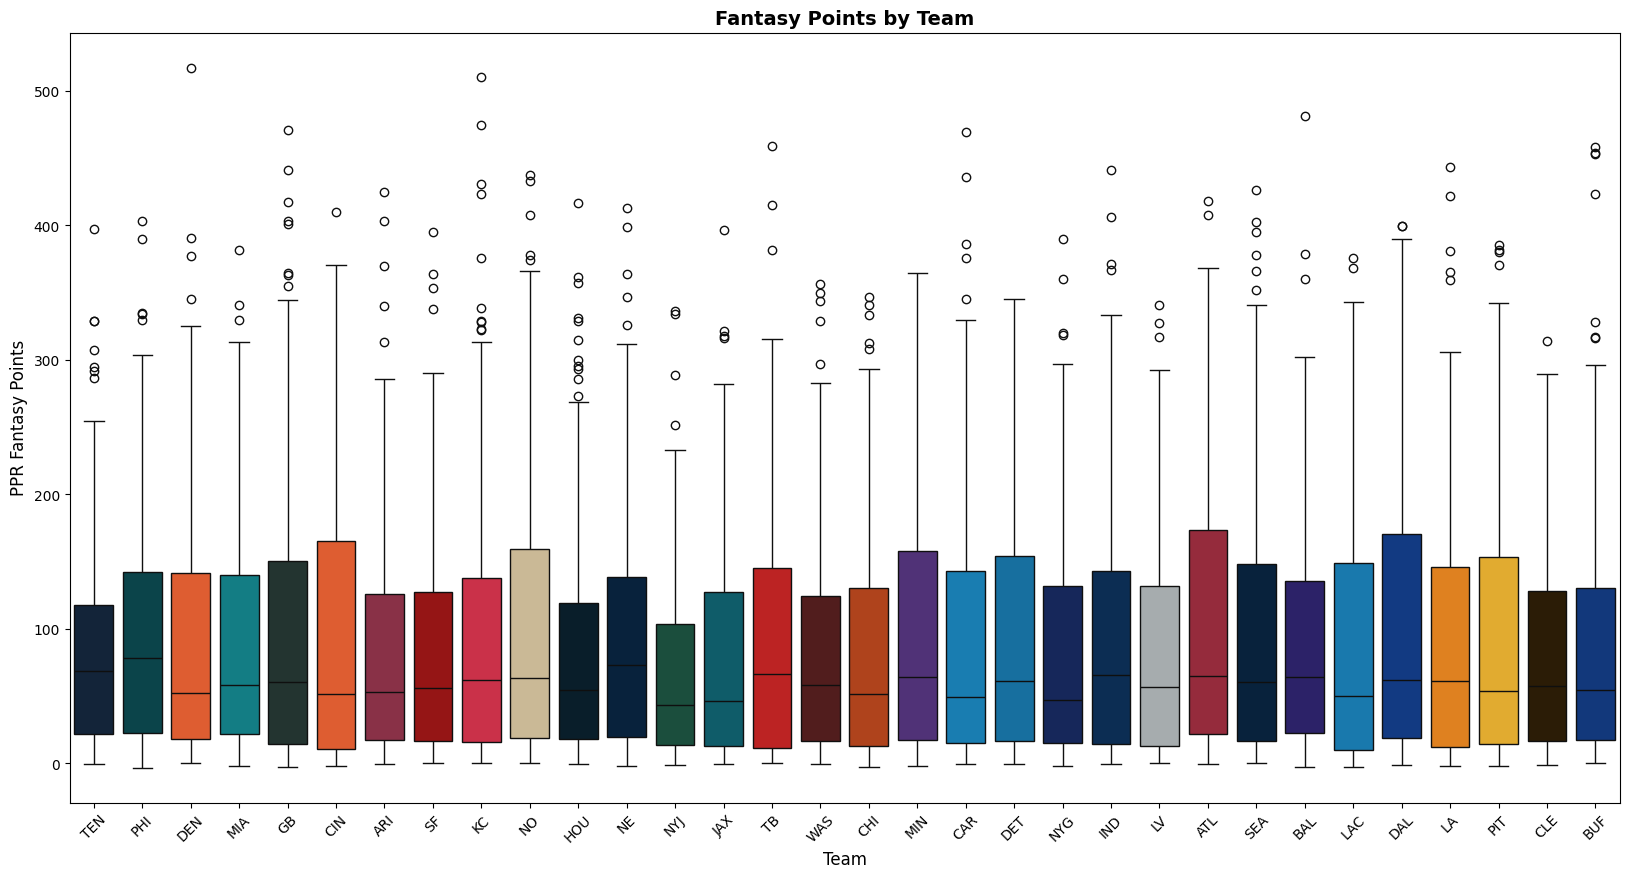

In [31]:
# Create boxplots of Fantasy Points for each team
plt.figure(figsize=(20, 10))
sns.boxplot(data=yearly_player_data, x='team', y='fantasy_points_ppr', palette=nfl_team_colors)
plt.title("Fantasy Points by Team", fontsize=14, fontweight='bold')
plt.xlabel("Team", fontsize=12)
plt.ylabel("PPR Fantasy Points", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [32]:
# Create position color palette
position_colors = {
    'QB': '#6F2DA8',
    'RB': '#00A36C',
    'WR': '#FB4F14',
    'TE': '#0085CA'
}

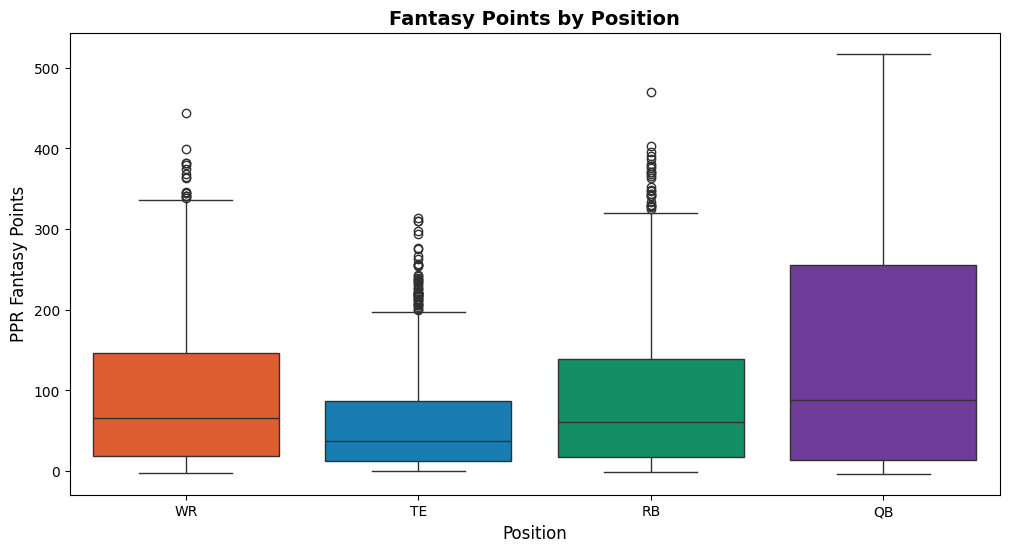

In [33]:
# Create boxplot of Fantasy Points by Position
plt.figure(figsize=(12, 6))
sns.boxplot(data=yearly_player_data, x='position', y='fantasy_points_ppr', palette=position_colors)
plt.title("Fantasy Points by Position", fontsize=14, fontweight='bold')
plt.xlabel("Position", fontsize=12)
plt.ylabel("PPR Fantasy Points", fontsize=12)
plt.show()

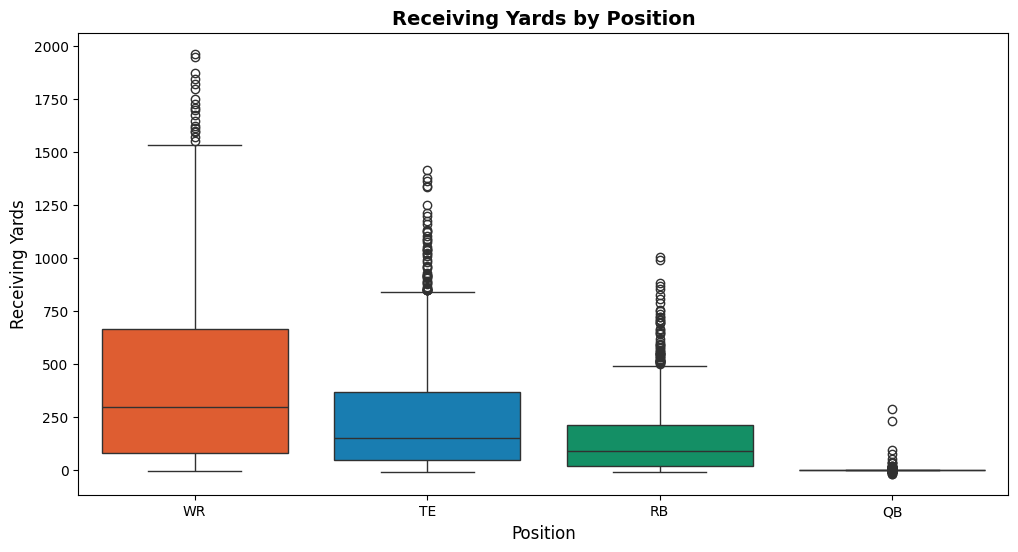

In [34]:
# Create boxplot of Receiving Yards by Position
plt.figure(figsize=(12, 6))
sns.boxplot(data=yearly_player_data, x='position', y='receiving_yards', palette=position_colors)
plt.title("Receiving Yards by Position", fontsize=14, fontweight='bold')
plt.xlabel("Position", fontsize=12)
plt.ylabel("Receiving Yards", fontsize=12)
plt.show()

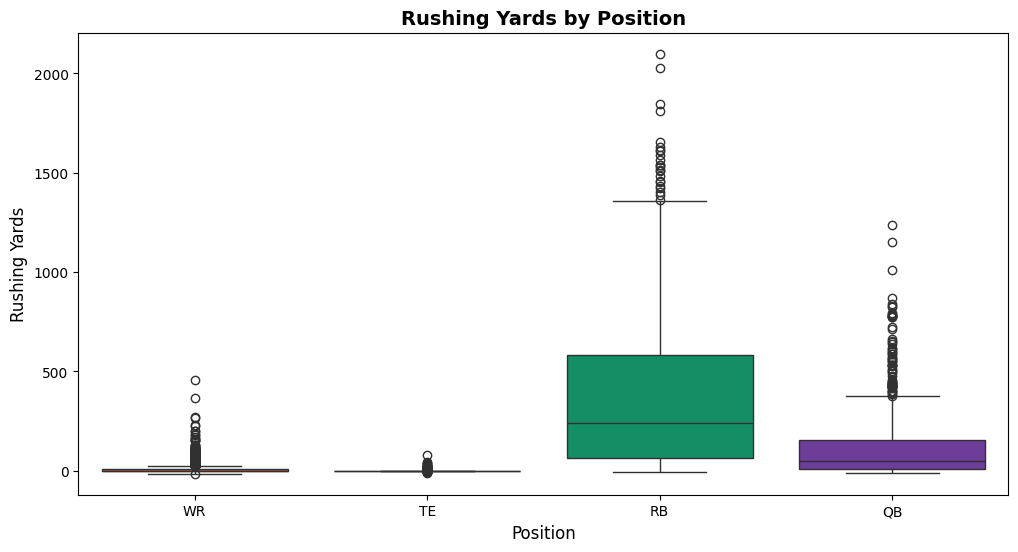

In [35]:
# Create boxplot of Rushing Yards by Position
plt.figure(figsize=(12, 6))
sns.boxplot(data=yearly_player_data, x='position', y='rushing_yards', palette=position_colors)
plt.title("Rushing Yards by Position", fontsize=14, fontweight='bold')
plt.xlabel("Position", fontsize=12)
plt.ylabel("Rushing Yards", fontsize=12)
plt.show()

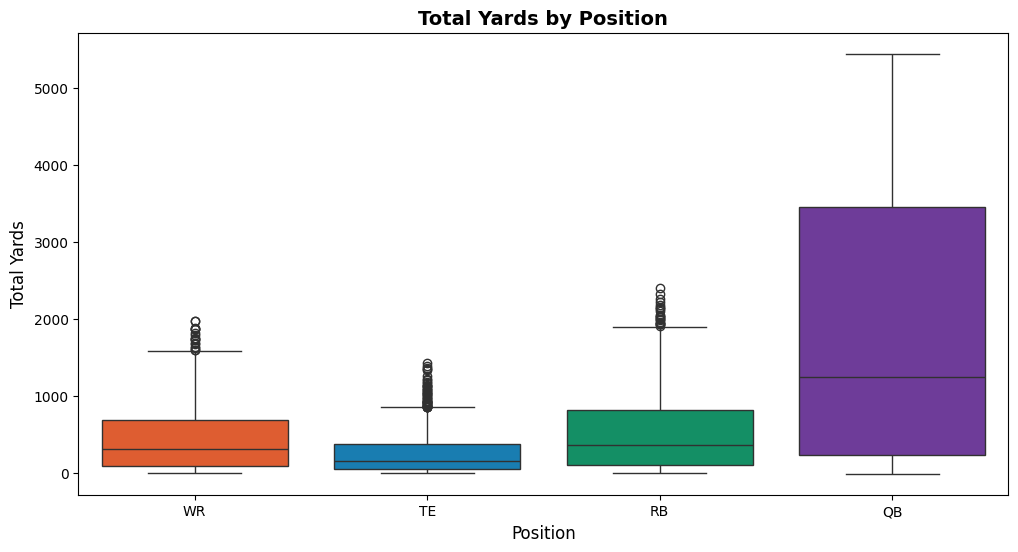

In [36]:
# Create boxplot of Total Yards by Position
plt.figure(figsize=(12, 6))
sns.boxplot(data=yearly_player_data, x='position', y='total_yards', palette=position_colors)
plt.title("Total Yards by Position", fontsize=14, fontweight='bold')
plt.xlabel("Position", fontsize=12)
plt.ylabel("Total Yards", fontsize=12)
plt.show()

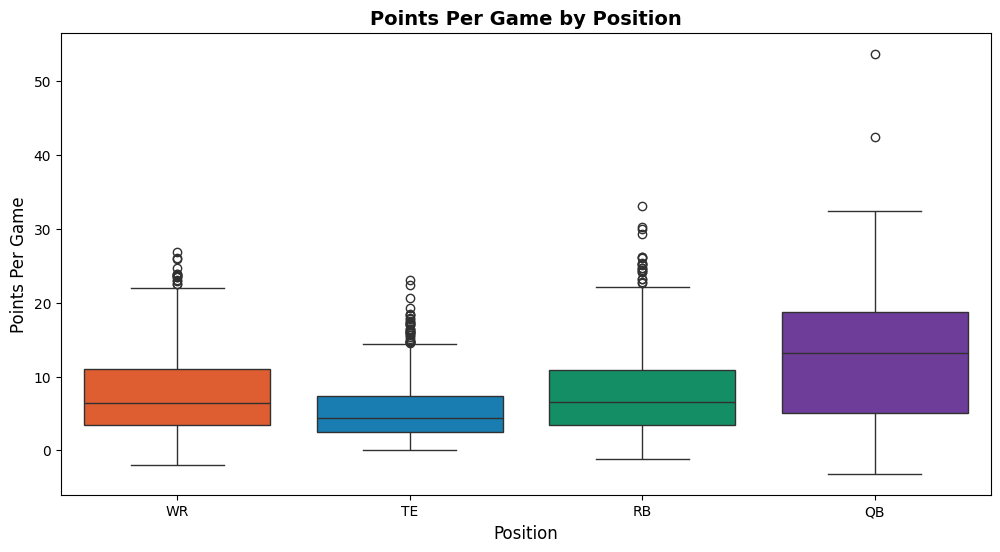

In [37]:
# Create boxplot of Points Per Game by Position
plt.figure(figsize=(12, 6))
sns.boxplot(data=yearly_player_data, x='position', y='ppg', palette=position_colors)
plt.title("Points Per Game by Position", fontsize=14, fontweight='bold')
plt.xlabel("Position", fontsize=12)
plt.ylabel("Points Per Game", fontsize=12)
plt.show()

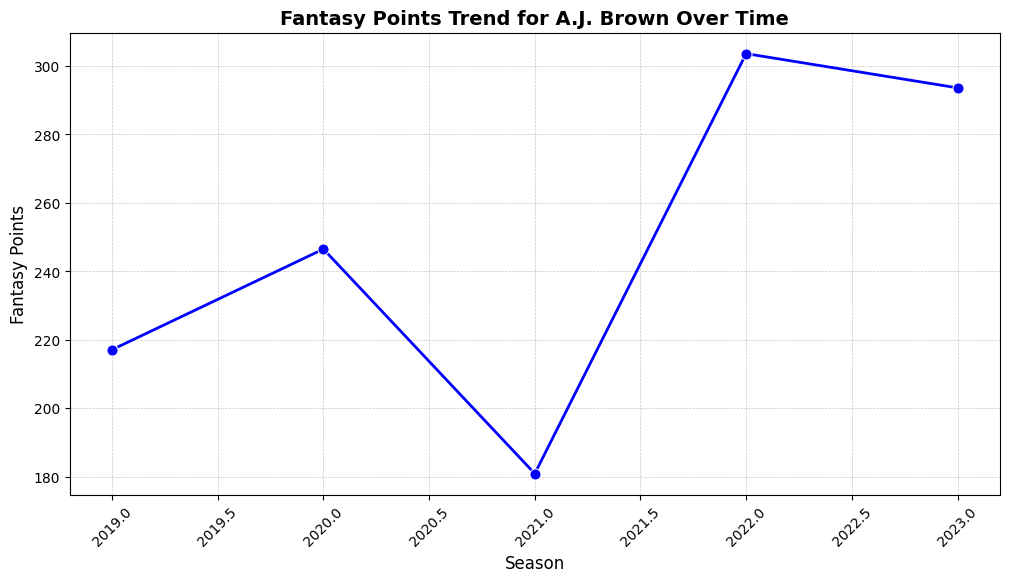

In [38]:
# Plot Fantasy Point trend for AJ Brown
selected_player = 'A.J. Brown'
player_data = yearly_player_data.loc[yearly_player_data['player_name'] == selected_player]

plt.figure(figsize=(12, 6))
sns.lineplot(data=player_data, x='season', y='fantasy_points_ppr', marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45)

plt.title("Fantasy Points Trend for {} Over Time".format(selected_player), fontsize=14, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Fantasy Points", fontsize=12)
plt.show()

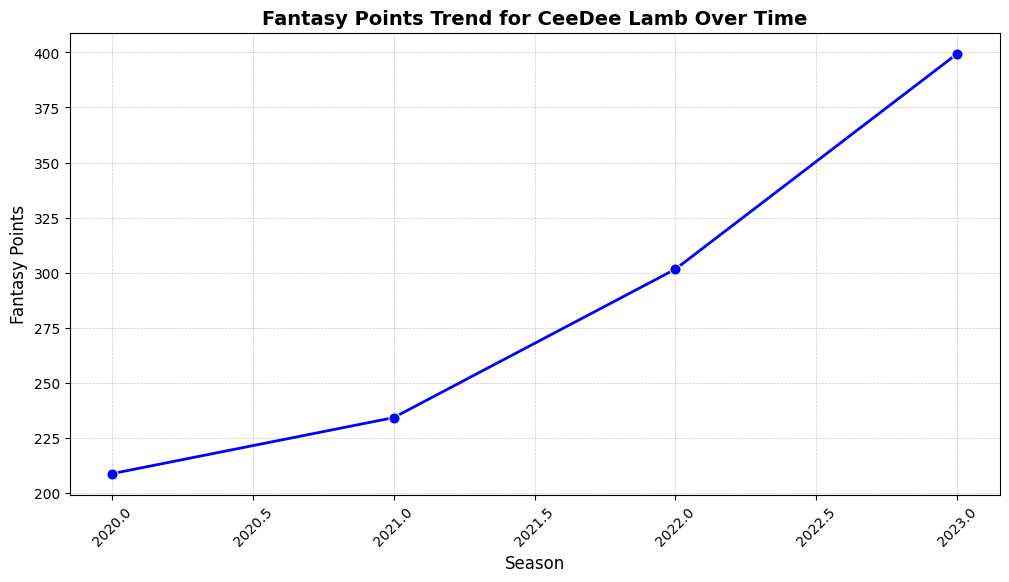

In [39]:
selected_player = 'CeeDee Lamb'
player_data = yearly_player_data.loc[yearly_player_data['player_name'] == selected_player]

plt.figure(figsize=(12, 6))
sns.lineplot(data=player_data, x='season', y='fantasy_points_ppr', marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45)

plt.title("Fantasy Points Trend for {} Over Time".format(selected_player), fontsize=14, fontweight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Fantasy Points", fontsize=12)
plt.show()

### Feature Engineering

The data has been cleaned but there is still an enormously large amount of features. Here we will choose the best features to be used in the modeling.

**Finding Pairs of Correlated Features**

Here we will check if the independent features are highly correlated with themselves.

In [40]:
# Remove 'average' and 'delta' features
yearly_player_data = yearly_player_data.drop(columns=[col for col in yearly_player_data.columns if any(word in col.lower() for word in ['average', 'delta', 'career'])])

In [41]:
# Check for correlations greater than 0.9
def find_highly_correlated_pairs():
    correlation_matrix = yearly_player_data.select_dtypes(include=['int64', 'float64']).corr().round(2)
    high_corr = correlation_matrix.abs() > 0.9

    np.fill_diagonal(high_corr.values, False)

    # Get highly correlated pairs
    high_corr_pairs = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if high_corr.iloc[i, j]:
                high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    for pair in high_corr_pairs:
        print(f"Highly correlated features: {pair[0]} and {pair[1]}")

In [42]:
find_highly_correlated_pairs()

Highly correlated features: complete_pass and pass_attempts
Highly correlated features: incomplete_pass and pass_attempts
Highly correlated features: incomplete_pass and complete_pass
Highly correlated features: passing_yards and pass_attempts
Highly correlated features: passing_yards and complete_pass
Highly correlated features: passing_yards and incomplete_pass
Highly correlated features: passing_air_yards and pass_attempts
Highly correlated features: passing_air_yards and complete_pass
Highly correlated features: passing_air_yards and incomplete_pass
Highly correlated features: passing_air_yards and passing_yards
Highly correlated features: pass_td and pass_attempts
Highly correlated features: pass_td and complete_pass
Highly correlated features: pass_td and incomplete_pass
Highly correlated features: pass_td and passing_yards
Highly correlated features: pass_td and passing_air_yards
Highly correlated features: interception and pass_attempts
Highly correlated features: interception 

In [43]:
# Remove some highly correlated features
yearly_player_data = yearly_player_data.drop(columns=[
    'passing_air_yards',
    'receiving_air_yards',
    'air_yards_share',
    'target_share',
    'rec_ypg',
    'pass_ypg',
    'comp_pct',
    'rush_ypg',
    'team_pass_snaps_count',
    'team_yards_gained',
    'team_complete_pass',
    'team_receiving_yards',
    'team_receiving_td',
    'offense_pct',
    'yards_pct',
    'wins',
    'losses',
    'ppg',
])

In [44]:
find_highly_correlated_pairs()

Highly correlated features: complete_pass and pass_attempts
Highly correlated features: incomplete_pass and pass_attempts
Highly correlated features: incomplete_pass and complete_pass
Highly correlated features: passing_yards and pass_attempts
Highly correlated features: passing_yards and complete_pass
Highly correlated features: passing_yards and incomplete_pass
Highly correlated features: pass_td and pass_attempts
Highly correlated features: pass_td and complete_pass
Highly correlated features: pass_td and incomplete_pass
Highly correlated features: pass_td and passing_yards
Highly correlated features: interception and pass_attempts
Highly correlated features: interception and complete_pass
Highly correlated features: interception and incomplete_pass
Highly correlated features: interception and passing_yards
Highly correlated features: receptions and targets
Highly correlated features: receiving_yards and targets
Highly correlated features: receiving_yards and receptions
Highly corre

In [45]:
# Get numerical features with good correlation to target
correlation_matrix = yearly_player_data.select_dtypes(include=['int64', 'float64']).corr().round(2)

corr_with_target = correlation_matrix['fantasy_points_ppr']

selected_features = corr_with_target[(corr_with_target > 0.3) | (corr_with_target < -0.3)].sort_values(ascending=False)
#len(selected_features)
selected_features

,fantasy_points_ppr
fantasy_points_ppr,1.00
total_yards,0.84
total_tds,0.83
games,0.76
offense_snaps,0.76
touches,0.75
ypg,0.66
receptions,0.61
yards_after_catch,0.61
targets,0.58


In [46]:
# Create reference dataset to use later when presenting predictions alongside player info
player_info = yearly_player_data[['season', 'player_name', 'position', 'team', 'college', 'age', 'height', 'weight', 'depth']]
yearly_player_data = yearly_player_data.drop(columns=['player_id', 'player_name', 'college'])

In [47]:
# Keep only features from selected_features
numerical_features_to_keep = selected_features.index.tolist()
numerical_features = yearly_player_data[numerical_features_to_keep]

In [48]:
categorical_features = yearly_player_data.select_dtypes(include=['object'])
categorical_features

,team,position
0,TEN,WR
1,TEN,WR
2,TEN,WR
3,PHI,WR
4,PHI,WR
...,...,...
5658,LV,WR
5659,JAX,WR
5660,JAX,WR
5661,NYJ,RB


In [49]:
# Join selected features to remaining categorical features
X = categorical_features.join(numerical_features)

In [50]:
# Get team's mean fantasy points
team_impact = yearly_player_data.groupby('team')['fantasy_points_ppr'].mean().sort_values(ascending=False)
print(team_impact)

team
DAL    106.213678
ATL    105.654201
NO     104.218201
GB     100.912333
KC     100.706552
MIN     98.710349
PIT     98.552386
NE      97.680541
SEA     97.253636
DET     97.230889
LA      96.283279
PHI     96.257444
TB      95.282935
LAC     93.524174
LV      92.858413
CIN     91.170870
IND     90.547619
BUF     90.103297
DEN     89.098969
CAR     88.991273
BAL     88.308191
MIA     88.013191
TEN     86.095055
SF      84.272500
HOU     84.108083
CHI     83.090526
ARI     82.802010
CLE     81.905810
WAS     80.875490
JAX     79.702487
NYG     79.668889
NYJ     68.105231
Name: fantasy_points_ppr, dtype: float64


In [51]:
# Get each teams mean contribution to fantasy points and create a new column
team_avg_fantasy_points = yearly_player_data.groupby('team')['fantasy_points_ppr'].mean()
X['team_avg_fantasy_points'] = X['team'].map(team_avg_fantasy_points)
X.drop(columns=['team'], inplace=True)

Rather than One Hot Encode 32 teams and create a large amount of new features, I opted to see what each team's mean contribution to fantasy points was and used that.

In [52]:
# Prepare features and target
X = X.drop(columns='fantasy_points_ppr')
y = yearly_player_data['fantasy_points_ppr']

In [53]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
position_encoded = ohe.fit_transform(X[['position']])
X_vif = pd.concat([X, position_encoded], axis=1).drop(columns=['position'])

**Calculate VIF (Variance Inflation Factor)**

We are calculating VIF to check for multicollinearity between the features. This will help us understand which features are highly correlated with each other and might need to be dropped.

In [54]:
X_with_const = add_constant(X_vif)

def get_vif_data():
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    print(vif_data.sort_values(by='VIF', ascending=False))

get_vif_data()

                    feature          VIF
1               total_yards          inf
15            pass_attempts          inf
2                 total_tds          inf
7                receptions          inf
5                   touches          inf
14             reception_td          inf
12            passing_yards          inf
11                  pass_td          inf
10          receiving_yards          inf
32              position_WR          inf
31              position_TE          inf
30              position_RB          inf
29              position_QB          inf
19            rushing_yards          inf
21            rush_attempts          inf
17                   run_td          inf
13            complete_pass  1306.302638
16          incomplete_pass   356.430610
26                draft_ovr    61.372542
9                   targets    61.008419
25              draft_round    53.489635
18             interception    10.372987
6                       ypg     9.957831
8         yards_

In [55]:
# Remove very high VIF/redundant features
X_with_const = X_with_const.drop(columns=['draft_round', 'draft_pick', 'total_yards', 'total_tds', 'rush_attempts', 'pass_attempts', 'targets', 'complete_pass', 'touches', 'incomplete_pass', 'passing_yards', 'receptions'])

In [56]:
get_vif_data()

                    feature        VIF
17              position_QB        inf
20              position_WR        inf
19              position_TE        inf
18              position_RB        inf
5           receiving_yards  11.591304
3                       ypg   8.924530
10            rushing_yards   6.928074
6                   pass_td   6.695240
4         yards_after_catch   6.033260
9              interception   5.953411
2             offense_snaps   5.314320
8                    run_td   4.403265
11         pass_fumble_lost   3.919036
7              reception_td   3.718903
1                     games   3.268445
13            passer_rating   2.464355
15                    depth   1.951132
12          run_fumble_lost   1.631841
14                draft_ovr   1.339292
16  team_avg_fantasy_points   1.039479
0                     const   0.000000


**Train/Test Split and Preprocess**

In [57]:
X = X.drop(columns=['draft_round', 'draft_pick', 'total_yards', 'total_tds', 'rush_attempts', 'pass_attempts', 'targets', 'complete_pass', 'touches', 'incomplete_pass', 'passing_yards', 'receptions'])

In [58]:
# Split data and preprocess
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_train) # Fit on train and transform
X_test_processed = preprocessor.transform(X_test) # Only transform (no fitting)

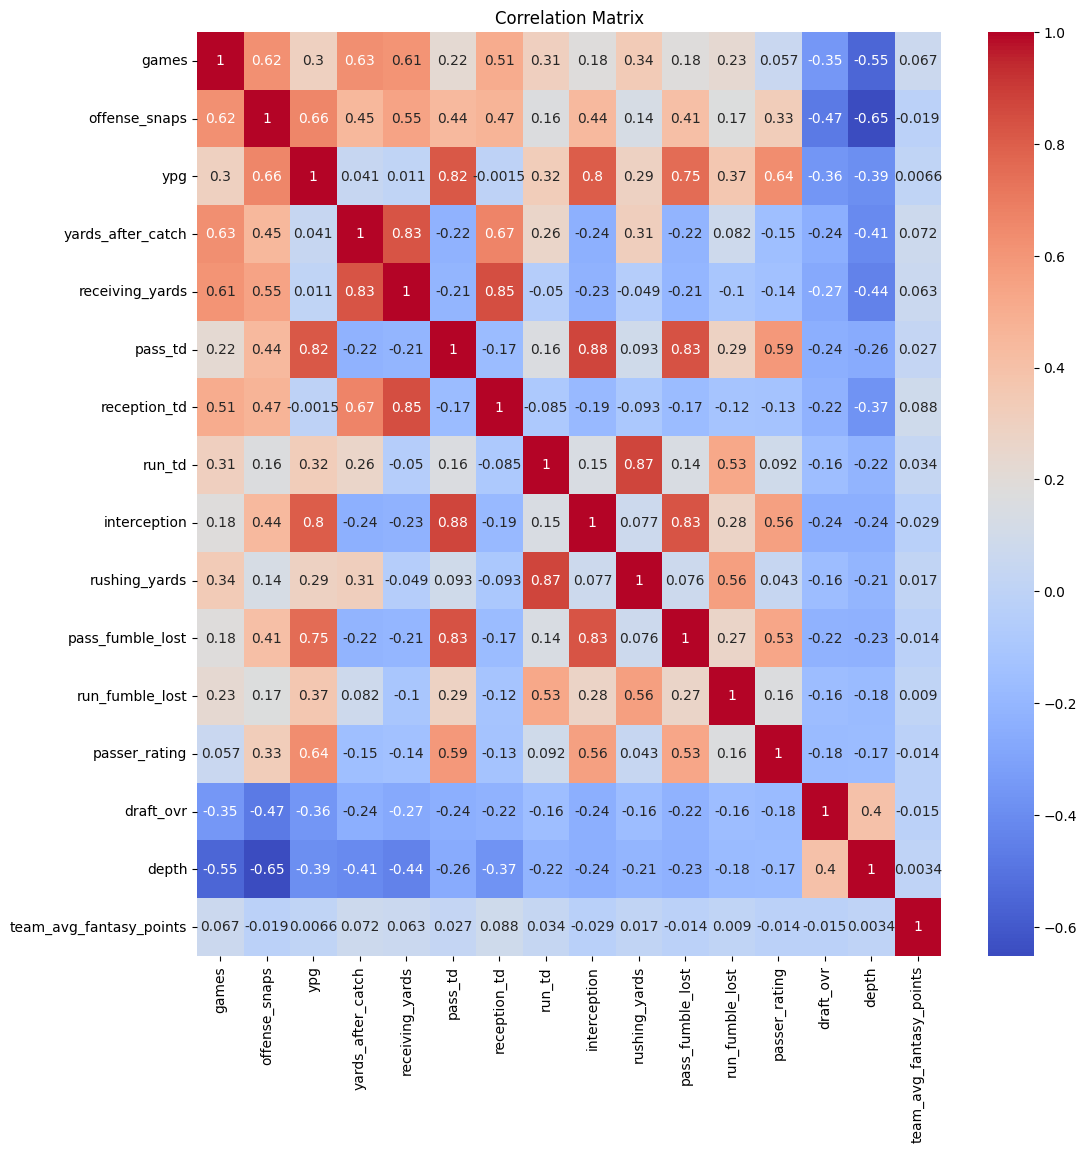

In [59]:
corr_matrix = X_train.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Modeling

For the models, we want to prioritize RMSE. We want the fantasy point predictions to be as close to the real points as we can get, therefore the model with the lowest test MSE will give us the most precise fantasy football projections.

**Modeling Function**

In [60]:
def train_and_evaluate_model(model, model_name, param_grid=None):
    """
    Train and evaluate a model. If param_grid is provided, performs hyperparameter tuning using GridSearchCV.

    Parameters:
        model (sklearn model): The machine learning model to train.
        model_name (str): The name of the model.
        param_grid (dict, optional): Hyperparameter grid for tuning.

    Returns:
        pd.DataFrame: Dataframe containing model performance metrics.
    """
    results = []

    if param_grid:
        print("Performing Grid Search for {}...".format(model_name))
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        # Fit model and time it
        start_time = time.time()
        grid_search.fit(X_train_processed, y_train)
        fit_time = time.time() - start_time

        # Get best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print("Best parameters for {}: {}".format(model_name, best_params))
    else:
        best_model = model
        best_params = None

        # Fit model and time it
        start_time = time.time()
        best_model.fit(X_train_processed, y_train)
        fit_time = time.time() - start_time

    # Predict on training set
    y_train_pred = best_model.predict(X_train_processed)

    # Predict on test set
    y_test_pred = best_model.predict(X_test_processed)

    # Evaluate
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Append results
    results.append({
        'Model': model_name,
        'Best Params': best_params,
        'Fit Time': fit_time,
        'Train R2 Score': train_r2,
        'Test R2 Score': test_r2,
        'Train MSE': train_mse,
        'Test MSE': test_mse
    })

    return pd.DataFrame(results), best_model

**Baseline Model**

For the baseline model, we will use a Linear Regression model with default parameters.

In [61]:
baseline_model = LinearRegression()
baseline_results, baseline_best_model = train_and_evaluate_model(baseline_model, "Linear Regression")
baseline_results

,Model,Best Params,Fit Time,Train R2 Score,Test R2 Score,Train MSE,Test MSE
0,Linear Regression,None,0.024644,0.993962,0.993936,52.264029,52.529066


**Individual Models**

In [62]:
# Param grid for hyperparameter tuning
models_with_params = {
    'Ridge': {
        'model': Ridge(),
        'param_grid': {'alpha': [0.1, 1, 10, 100]}
    },
    'Lasso': {
        'model': Lasso(),
        'param_grid': {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=42),
        'param_grid': {
            'max_depth': [None, 3, 5, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4, 5, 10, 20]
        }
    },
    'SVR': {
        'model': SVR(),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
}

In [63]:
# Train models
results_list = []
best_models = {}

for name, config in models_with_params.items():
    model = config['model']
    param_grid = config['param_grid']

    results_df, trained_model = train_and_evaluate_model(model, name, param_grid=param_grid)
    results_list.append(results_df)
    best_models[name] = trained_model

individual_models_results = pd.concat(results_list, ignore_index=True)
individual_models_results_sorted = individual_models_results.sort_values(by='Test MSE', ascending=True)
individual_models_results_sorted

Performing Grid Search for Ridge...
Best parameters for Ridge: {'alpha': 0.1}
Performing Grid Search for Lasso...
Best parameters for Lasso: {'alpha': 0.0001}
Performing Grid Search for KNeighborsRegressor...
Best parameters for KNeighborsRegressor: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Performing Grid Search for DecisionTreeRegressor...
Best parameters for DecisionTreeRegressor: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Performing Grid Search for SVR...
Best parameters for SVR: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


,Model,Best Params,Fit Time,Train R2 Score,Test R2 Score,Train MSE,Test MSE
4,SVR,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",136.127911,0.993655,0.993952,54.918600,52.391266
1,Lasso,{'alpha': 0.0001},0.247578,0.993962,0.993936,52.264030,52.528593
0,Ridge,{'alpha': 0.1},2.598899,0.993962,0.993935,52.264056,52.538132
3,DecisionTreeRegressor,"{'max_depth': None, 'min_samples_leaf': 4, 'mi...",11.695464,0.993841,0.977536,53.309814,194.592089
2,KNeighborsRegressor,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",3.907315,1.000000,0.974586,0.000000,220.148222


Here we can see that the Decision Tree and KNeighbors models are not performing well at all. Ridge, Lasso, and SVR all performed well and will be included in the ensemble model.

**Ensemble Model**

In [64]:
voting_regressor = VotingRegressor([
    ('ridge', best_models['Ridge']),
    ('lasso', best_models['Lasso']),
    ('svr', best_models['SVR'])
])

ensemble_model_result, best_ensemble = train_and_evaluate_model(voting_regressor, 'Voting Regressor')
ensemble_model_result

,Model,Best Params,Fit Time,Train R2 Score,Test R2 Score,Train MSE,Test MSE
0,Voting Regressor,None,1.459739,0.993928,0.994041,52.558465,51.622275


**Trying Polynomial Features**

In [65]:
def train_and_evaluate_poly_model(model, model_name, param_grid=None):
    """
    Train and evaluate a model on polynomial features. If param_grid is provided, performs hyperparameter tuning using GridSearchCV.

    Parameters:
        model (sklearn model): The machine learning model to train.
        model_name (str): The name of the model.
        param_grid (dict, optional): Hyperparameter grid for tuning.

    Returns:
        pd.DataFrame: Dataframe containing model performance metrics.
    """
    results = []

    if param_grid:
        print("Performing Grid Search for {}...".format(model_name))
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        # Fit model and time it
        start_time = time.time()
        grid_search.fit(X_train_poly, y_train)
        fit_time = time.time() - start_time

        # Get best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print("Best parameters for {}: {}".format(model_name, best_params))
    else:
        best_model = model
        best_params = None

        # Fit model and time it
        start_time = time.time()
        best_model.fit(X_train_poly, y_train)
        fit_time = time.time() - start_time

    # Predict on training set
    y_train_pred = best_model.predict(X_train_poly)

    # Predict on test set
    y_test_pred = best_model.predict(X_test_poly)

    # Evaluate
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Append results
    results.append({
        'Model': model_name,
        'Best Params': best_params,
        'Fit Time': fit_time,
        'Train R2 Score': train_r2,
        'Test R2 Score': test_r2,
        'Train MSE': train_mse,
        'Test MSE': test_mse
    })

    return pd.DataFrame(results), best_model

In [66]:
# Apply polynomial transformations
poly = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()

X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

In [67]:
# Param grid for hyperparameter tuning
models_with_params_poly = {
    "Ridge": {'model': Ridge(), 'param_grid': {'alpha': [0.1, 1, 10, 100]}},
    "Lasso": {'model': Lasso(), 'param_grid': {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}},
    "SVR": {'model': SVR(), 'param_grid': {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf'], 'gamma': ['scale', 'auto']}}
}

In [68]:
# Train models
results_list_poly = []
best_poly_models = {}
for name, config in models_with_params_poly.items():
    model = config['model']
    param_grid = config['param_grid']
    results_df, trained_model = train_and_evaluate_poly_model(model, name, param_grid=param_grid)
    results_list_poly.append(results_df)
    best_poly_models[name] = trained_model

individual_models_results_poly = pd.concat(results_list_poly, ignore_index=True)
individual_models_results_poly = individual_models_results_poly.sort_values(by='Test MSE', ascending=True)
individual_models_results_poly

Performing Grid Search for Ridge...
Best parameters for Ridge: {'alpha': 1}
Performing Grid Search for Lasso...
Best parameters for Lasso: {'alpha': 0.01}
Performing Grid Search for SVR...
Best parameters for SVR: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


,Model,Best Params,Fit Time,Train R2 Score,Test R2 Score,Train MSE,Test MSE
1,Lasso,{'alpha': 0.01},25.540226,0.997298,0.997426,23.387575,22.298578
2,SVR,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",2843.016990,0.997253,0.997376,23.775695,22.731808
0,Ridge,{'alpha': 1},0.659115,0.997340,0.997318,23.027075,23.236310


In [73]:
poly_voting_regressor = VotingRegressor([
    ('ridge', best_poly_models['Ridge']),
    ('lasso', best_poly_models['Lasso']),
    ('svr', best_poly_models['SVR'])
])

poly_ensemble_model_result, best_ensemble = train_and_evaluate_poly_model(poly_voting_regressor, 'Voting Regressor')
poly_ensemble_model_result

,Model,Best Params,Fit Time,Train R2 Score,Test R2 Score,Train MSE,Test MSE
0,Voting Regressor,None,250.450018,0.997319,0.997394,23.208732,22.576976


Using polynomial features resulted in a great improvement of our models. Choosing either the individual Lasso model with alpha 0.01 or the ensemble model would be great choices.

**Neural Network**

In [89]:
# Create Dense Neural Network
tf.random.set_seed(42)

nn_model = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(loss='mean_squared_error', metrics=['mse'])

history = nn_model.fit(X_train_poly, y_train, validation_data=(X_test_poly, y_test), epochs=100, batch_size=32, verbose=0)

In [93]:
#Evaluate model
y_train_pred_nn = nn_model.predict(X_train_poly)
y_test_pred_nn = nn_model.predict(X_test_poly)

train_r2_nn = r2_score(y_train, y_train_pred_nn)
test_r2_nn = r2_score(y_test, y_test_pred_nn)

train_mse_nn = mean_squared_error(y_train, y_train_pred_nn)
test_mse_nn = mean_squared_error(y_test, y_test_pred_nn)

print(f"Neural Network - Train R2: {train_r2_nn}")
print(f"Neural Network - Test R2: {test_r2_nn}")
print(f"Neural Network - Train MSE: {train_mse_nn}")
print(f"Neural Network - Test MSE: {test_mse_nn}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network - Train R2: 0.9955501371906168
Neural Network - Test R2: 0.9939602135692893
Neural Network - Train MSE: 38.51802315138202
Neural Network - Test MSE: 52.3188374523708
